In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
print ('scikit-learn version: ', sklearn.__version__)
import seaborn as sns
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

scikit-learn version:  0.22.2.post1


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/LOCP(B)")

from RLclustering import *

In [4]:
# calculating discrete derivates with 4 points (see wikipedia)
def finite_derivative(v):
    
    L = len(v)
    d1 = np.delete(v, [L-4, L-3, L-2, L-1])              #f[x+2]
    d2 = np.delete(v, [0,L-3,L-2,L-1])                   #f[x+1]
    d3 = np.delete(v, [0, 1, 2, L-1])                    #f[x-1]
    d4 = np.delete(v, [0,1,2,3])                         #f[x-2]
    
    return (-d1+8*d2-8*d3+d4)/12

In [5]:
days = ("sunday", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday") 

# indoor
df_in = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/Ringebu_DL1_year.csv" , names=['n','Data', 'RH', 'T'], header=0)
df_mr = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/mixing_ratio_DL1_year.csv" , names=['n','Data', 'MR'], header=0)
# outdoor
df_out = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/Ringebu_DL3_year.csv" , names=['n','Data', 'RH', 'T'], header=0)
df_mr3 = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/mixing_ratio_DL3_year.csv" , names=['n','Data', 'MR'], header=0)

metadata_df = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/Metadata_Ringebu.csv" ,names=['n',"Start","Duration","End","Event","People","Start Heating"], header=0)

# converting string do datetime
df_in['Data'] = pd.to_datetime(df_in['Data'], format='%Y-%m-%d %H:%M:%S')
df_out['Data'] = pd.to_datetime(df_out['Data'], format='%Y-%m-%d %H:%M:%S')
metadata_df['Start'] = pd.to_datetime(metadata_df['Start'], format='%m/%d/%Y %H:%M')

# creating new colums, useful for analysis
df_in['Day'] = [ days[ df_in['Data'][i].weekday() ] for i in range(len(df_in['Data']))]
df_in['Day_number'] = [  df_in['Data'][i].timetuple().tm_yday  for i in range(len(df_in['Data']))]
df_in['MR'] = df_mr['MR']

df_out['Day'] = [ days[ df_out['Data'][i].weekday() ] for i in range(len(df_out['Data']))]
df_out['Day_number'] = [  df_out['Data'][i].timetuple().tm_yday  for i in range(len(df_out['Data']))]
df_out['MR'] = df_mr3['MR']

metadata_df['Day_number'] = [metadata_df['Start'][i].timetuple().tm_yday  for i in range(len(metadata_df['Start']))]

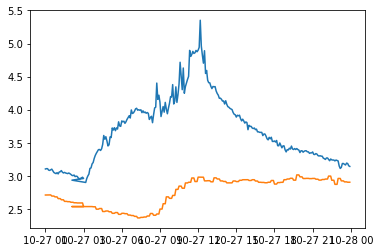

In [6]:
# Mixing ratio in a day with event
din = df_in[df_in["Day_number"] == 300]
dout = df_out[df_out["Day_number"] == 300]

plt.plot(din["Data"],din["MR"]);
plt.plot(din["Data"],dout["MR"]);

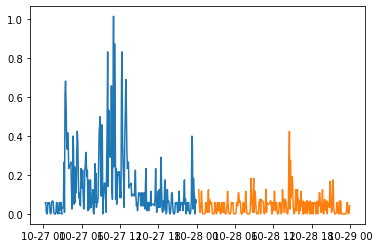

In [7]:
# Tin derivate in a day with event and with none (following)
din2 = df_in[df_in["Day_number"] == 301]

z = np.asarray(din["Data"])
x1 = np.delete(z, [0,1,2,3])  
z2 = np.asarray(din2["Data"])
x2 = np.delete(z2, [0,1,2,3])  

der300 = abs(finite_derivative(np.asarray(din["T"])))
der301 = abs(finite_derivative(np.asarray(din2["T"])))

plt.plot(x1,(der300));
plt.plot(x2,(der301));

In [14]:
# there can be only one day number 89 (see df_in printed before)
din = df_in[df_in["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
dout = df_out[df_out["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]

x = np.unique(din["Day_number"])
N = len(x)

# Possibili variabili da clusterizzare 
std_Tin = np.zeros(N)        # dev std di Tin 
std_Tout = np.zeros(N)       # dev std di Tout 
std_RHin = np.zeros(N)       # dev std di RHin 
std_diff_T = np.zeros(N)     # dev std di Tin-Tout
std_diff_RH = np.zeros(N)    # dev std di RHin-RHout
std_diff_MR = np.zeros(N)    # dev std di MRin-MRout
max_diff_MR = np.zeros(N)    # max di MRin-MRout

for i in range(N):
    data_in = din[din["Day_number"]==i+1]
    data_out = dout[dout["Day_number"]==i+1]
    
    std_Tin[i] = np.std( np.asarray(data_in["T"]) )
    std_Tout[i] = np.std( np.asarray(data_out["T"]) )
    std_RHin[i] = np.std( np.asarray(data_in["RH"]) )
    std_diff_T[i] = np.std( data_in["T"] - data_out["T"] )
    std_diff_RH[i] = np.std( data_in["RH"] - data_out["RH"] )
    std_diff_MR[i] = np.std( data_in["MR"] - data_out["MR"] )
    max_diff_MR[i] = np.max( data_in["MR"] - data_out["MR"] ) 

# quattro variabili scelte per ogni giorno in questa prova. Ogni vettore e' stato normalizzato con la sua media cosi' che tutti abbiano lo stesso peso
data = np.vstack(((std_Tin - np.mean(std_Tin))/np.std(std_Tin), 
                  (std_diff_T - np.mean(std_diff_T))/np.std(std_diff_T), 
                  (std_diff_MR - np.mean(std_diff_MR))/np.std(std_diff_MR), 
                  (std_diff_RH - np.mean(std_diff_RH))/np.std(std_diff_RH))).T

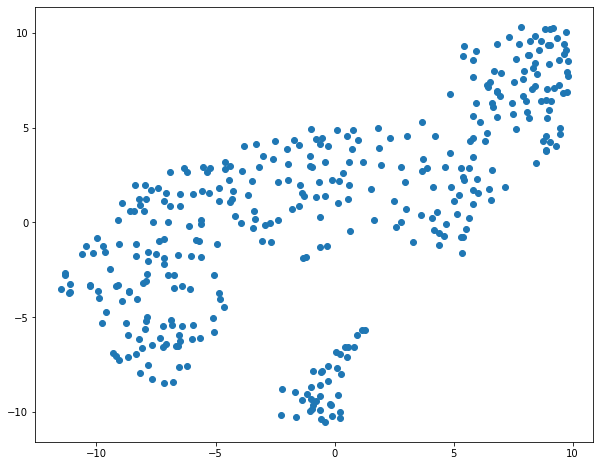

In [15]:
perpl = 60

fig, ax = plt.subplots(figsize=(10, 8))
tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, method='barnes_hut').fit_transform(data)
scat = ax.scatter(tsne_data[:,0],tsne_data[:,1])

=============================   5 clusters found   ============================


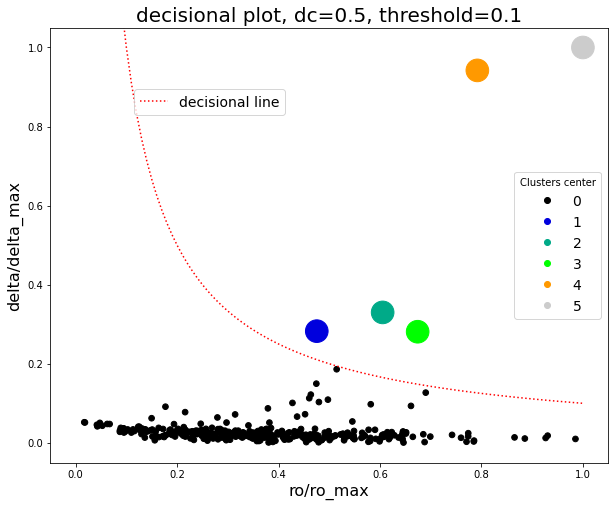

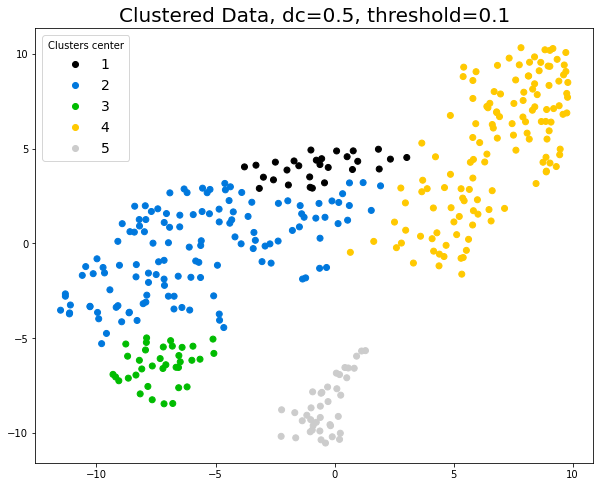

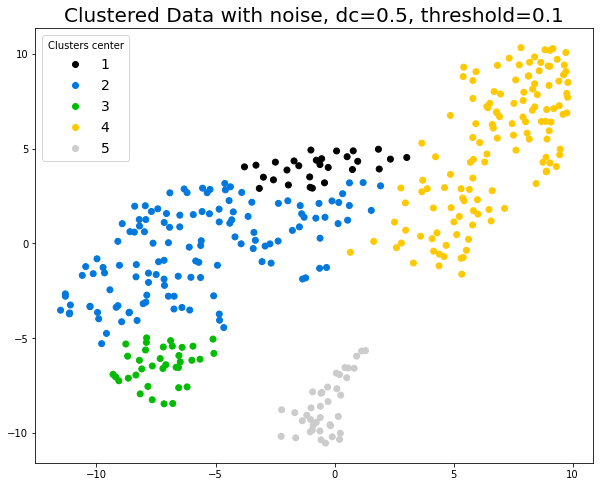

In [16]:
dc = 0.5
threshold = 0.1

BBR_tsne = RLclustering(tsne_data)
#BBR_tsne.nndist_histo((0,6),40);
BBR_tsne.clear_label()
BBR_tsne.ro_delta_graph(dc,gau_chi,threshold)
BBR_tsne.clusters_graph(dc,gau_chi,threshold,tsne_perplexity=perpl)
BBR_tsne.clusters_graph(dc,gau_chi,threshold, strictness=0, noise=True,tsne_perplexity=perpl);

In [17]:
BBR_tsne.get_centers_idx()

[23, 54, 161, 346, 357]